E0123047


In [ ]:
# blackjack_mc.py
# Minimal-from-scratch Blackjack + First-Visit MC Prediction + On-Policy MC Control
# No external deps except numpy. Works in any plain Python 3.x.

import numpy as np
from collections import defaultdict

# ---------------------------
# Blackjack environment (from scratch)
# ---------------------------

# We model an infinite deck with correct 10-card weighting:
# cards = {1,2,3,4,5,6,7,8,9,10} with P(10)=4/13, others 1/13.
_CARD_VALUES = np.array([1,2,3,4,5,6,7,8,9,10], dtype=int)
_CARD_PROBS  = np.array([1]*9 + [4], dtype=float) / 13.0

HIT, STICK = 1, 0

def draw_card(rng):
    return rng.choice(_CARD_VALUES, p=_CARD_PROBS)

def usable_ace(hand):
    # True if hand contains at least one Ace counted as 11 without bust
    return 1 in hand and hand_sum(hand, ace_as_eleven=True) <= 21

def hand_sum(hand, ace_as_eleven=False):
    s = sum(11 if (c == 1 and ace_as_eleven) else c for c in hand)
    # If we allowed 11 for an Ace and we bust, downgrade one (or more) Aces to 1
    if s > 21 and ace_as_eleven:
        # convert 11->1 for as many aces as needed
        aces = hand.count(1)
        while aces > 0 and s > 21:
            s -= 10
            aces -= 1
    return s

def hand_value_and_usable(hand):
    # Return (sum, usable_ace_bool) using best Ace treatment
    s_with = hand_sum(hand, ace_as_eleven=True)
    if s_with <= 21:
        return s_with, True if 1 in hand else False
    # else downgrade aces
    s_without = hand_sum(hand, ace_as_eleven=False)
    return s_without, False

class SimpleBlackjackEnv:
    """
    State: (player_sum, dealer_upcard, usable_ace_flag)
    Actions: 0=STICK, 1=HIT
    Reward: +1 win, 0 draw, -1 loss
    """
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.player = []
        self.dealer = []
        self.terminal = False
        self.reward = 0.0

    def _deal_start(self):
        self.player = [draw_card(self.rng), draw_card(self.rng)]
        self.dealer = [draw_card(self.rng), draw_card(self.rng)]
        self.terminal = False
        self.reward = 0.0

    def _current_state(self):
        ps, ua = hand_value_and_usable(self.player)
        up = self.dealer[0]
        return (ps, up, ua)

    def reset(self):
        self._deal_start()
        # If initial player sum < 12, force an extra hit (standard episodic tweak)
        # so that states start at 12+ (as in Sutton & Barto examples).
        while hand_value_and_usable(self.player)[0] < 12:
            self.player.append(draw_card(self.rng))
        return self._current_state()

    def step(self, action):
        if self.terminal:
            raise RuntimeError("Episode already over.")
        if action == HIT:
            self.player.append(draw_card(self.rng))
            ps, ua = hand_value_and_usable(self.player)
            if ps > 21:             # player busts
                self.terminal = True
                self.reward = -1.0
                return (ps, self.dealer[0], ua), -1.0, True
            return (ps, self.dealer[0], ua), 0.0, False
        else:  # STICK: dealer plays out
            # Dealer policy: hit until sum >= 17 (treat usable ace naturally)
            while True:
                ds, dua = hand_value_and_usable(self.dealer)
                if ds >= 17:
                    break
                self.dealer.append(draw_card(self.rng))
            ps, _ = hand_value_and_usable(self.player)
            ds, _ = hand_value_and_usable(self.dealer)
            self.terminal = True
            if ds > 21 or ps > ds:
                self.reward = +1.0
            elif ps == ds:
                self.reward = 0.0
            else:
                self.reward = -1.0
            s = self._current_state()
            return s, self.reward, True

# ---------------------------
# Policies
# ---------------------------

def fixed_policy(state):
    """Stick on 20 or 21, else hit."""
    player_sum, _, _ = state
    return STICK if player_sum >= 20 else HIT

def epsilon_greedy_policy(Q, state, epsilon, rng):
    if rng.random() < epsilon:
        return rng.integers(0, 2)  # 0 or 1
    # Break ties fairly by random argmax
    q0, q1 = Q[state][0], Q[state][1]
    if q0 == q1:
        return int(rng.integers(0, 2))
    return int(q1 > q0)

# ---------------------------
# Episode generation
# ---------------------------

def generate_episode(env, policy_fn, rng, Q=None, epsilon=None):
    """Return list of (state, action, reward) until terminal."""
    episode = []
    state = env.reset()
    done = False
    while not done:
        if Q is None:
            a = policy_fn(state)
        else:
            a = policy_fn(Q, state, epsilon, rng)
        ns, r, done = env.step(a)
        episode.append((state, a, r))
        state = ns
    return episode

# ---------------------------
# First-Visit MC Prediction
# ---------------------------

def mc_first_visit_prediction(num_episodes=200000, seed=1):
    env = SimpleBlackjackEnv(seed=seed)
    rng = np.random.default_rng(seed+7)
    V = defaultdict(float)
    returns = defaultdict(list)

    for _ in range(num_episodes):
        ep = generate_episode(env, fixed_policy, rng)
        seen = set()
        # Compute returns G backward
        G = 0.0
        for t in reversed(range(len(ep))):
            s, a, r = ep[t]
            G += r
            if s not in seen:
                returns[s].append(G)
                V[s] = np.mean(returns[s])
                seen.add(s)
    return V

# ---------------------------
# On-Policy MC Control (ε-soft)
# ---------------------------

def mc_on_policy_control(num_episodes=100000, epsilon_start=0.2, epsilon_end=0.02, seed=5):
    env = SimpleBlackjackEnv(seed=seed)
    rng = np.random.default_rng(seed+11)

    Q = defaultdict(lambda: np.zeros(2, dtype=float))
    returns = defaultdict(lambda: [[], []])  # returns[(s)][a] -> list

    for i in range(1, num_episodes + 1):
        # Linearly anneal epsilon
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * max(0.0, (num_episodes - i) / num_episodes)
        ep = generate_episode(env, epsilon_greedy_policy, rng, Q=Q, epsilon=epsilon)

        visited = set()
        G = 0.0
        for t in reversed(range(len(ep))):
            s, a, r = ep[t]
            G += r
            if (s, a) not in visited:
                returns[s][a].append(G)
                Q[s][a] = np.mean(returns[s][a])
                visited.add((s, a))
    return Q

# ---------------------------
# Pretty helpers
# ---------------------------

def print_sample_values(V):
    def v(ps, up, ua):
        return V.get((ps, up, ua), float('nan'))
    print("\nMC Prediction: V(s) for player_sum=12..21, dealer_up=1..10, usable_ace=False")
    for ps in range(12, 22):
        row = [f"{v(ps, up, False):5.2f}" for up in range(1, 11)]
        print(f"{ps:>2} | " + " ".join(row))

    print("\nMC Prediction: V(s) for player_sum=12..21, dealer_up=1..10, usable_ace=True")
    for ps in range(12, 22):
        row = [f"{v(ps, up, True):5.2f}" for up in range(1, 11)]
        print(f"{ps:>2} | " + " ".join(row))

def print_greedy_policy(Q):
    # Greedy action from Q (0=STICK, 1=HIT)
    def a(ps, up, ua):
        q = Q.get((ps, up, ua))
        if q is None: return "?"
        return "S" if q[STICK] >= q[HIT] else "H"

    print("\nGreedy policy from MC-Control (usable_ace=False). Rows: player 12..21, Cols: dealer 1..10")
    for ps in range(12, 22):
        row = [a(ps, up, False) for up in range(1, 11)]
        print(f"{ps:>2} | " + " ".join(row))

    print("\nGreedy policy from MC-Control (usable_ace=True). Rows: player 12..21, Cols: dealer 1..10")
    for ps in range(12, 22):
        row = [a(ps, up, True) for up in range(1, 11)]
        print(f"{ps:>2} | " + " ".join(row))

# ---------------------------
# Run both parts when file executed
# ---------------------------

if __name__ == "__main__":
    # PART 1: First-Visit MC Prediction under fixed policy (stick on 20+)
    V = mc_first_visit_prediction(num_episodes=300000, seed=17)
    print_sample_values(V)

    # PART 2: On-Policy MC Control (epsilon-soft -> greedy)
    Q = mc_on_policy_control(num_episodes=120000, epsilon_start=0.25, epsilon_end=0.02, seed=23)
    print_greedy_policy(Q)



MC Prediction: V(s) for player_sum=12..21, dealer_up=1..10, usable_ace=False
12 | -0.62 -0.55 -0.55 -0.55 -0.49 -0.52 -0.52 -0.50 -0.54 -0.56
13 | -0.63 -0.61 -0.57 -0.57 -0.56 -0.59 -0.55 -0.59 -0.57 -0.61
14 | -0.68 -0.61 -0.60 -0.62 -0.60 -0.61 -0.55 -0.56 -0.59 -0.62
15 | -0.73 -0.65 -0.63 -0.63 -0.63 -0.65 -0.64 -0.61 -0.64 -0.65
16 | -0.73 -0.65 -0.69 -0.67 -0.66 -0.64 -0.63 -0.64 -0.64 -0.68
17 | -0.76 -0.71 -0.69 -0.70 -0.68 -0.70 -0.66 -0.68 -0.66 -0.71
18 | -0.76 -0.70 -0.71 -0.72 -0.72 -0.71 -0.71 -0.67 -0.71 -0.72
19 | -0.77 -0.72 -0.75 -0.73 -0.70 -0.73 -0.72 -0.70 -0.71 -0.73
20 |  0.14  0.63  0.67  0.66  0.68  0.70  0.76  0.78  0.74  0.43
21 |  0.64  0.89  0.87  0.90  0.88  0.90  0.93  0.93  0.94  0.89

MC Prediction: V(s) for player_sum=12..21, dealer_up=1..10, usable_ace=True
12 | -0.56 -0.52 -0.39 -0.49 -0.50 -0.44 -0.44 -0.41 -0.44 -0.46
13 | -0.58 -0.50 -0.49 -0.47 -0.46 -0.40 -0.38 -0.43 -0.44 -0.49
14 | -0.59 -0.51 -0.47 -0.49 -0.44 -0.44 -0.43 -0.44 -0.47 -0.50


/tmp/ipython-input-3012700729.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


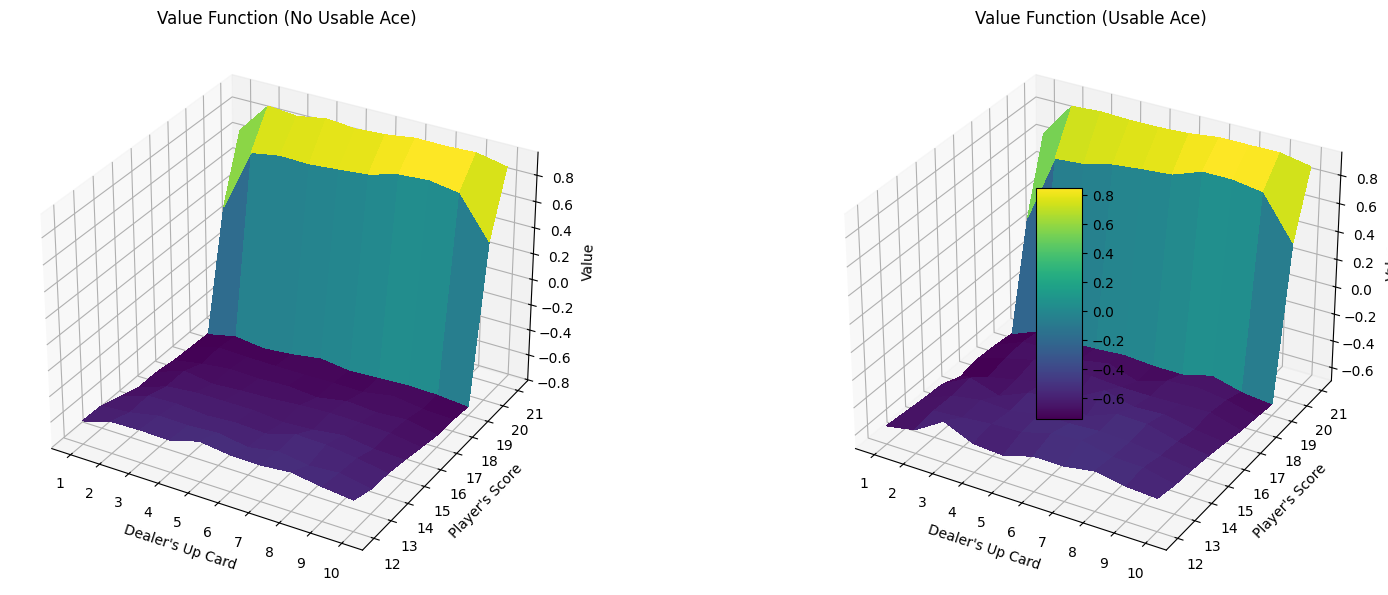

In [ ]:
# Assuming V is the result from mc_first_visit_prediction

# Prepare data for 3D plot
player_score_range = range(12, 22)
dealer_card_range = range(1, 11)

X, Y = np.meshgrid(dealer_card_range, player_score_range)

Z_nua = np.zeros(X.shape)
Z_ua = np.zeros(X.shape)

for i, player_score in enumerate(player_score_range):
    for j, dealer_card in enumerate(dealer_card_range):
        state_nua = (player_score, dealer_card, False)
        Z_nua[i, j] = V.get(state_nua, 0) # Use 0 for states not visited

        state_ua = (player_score, dealer_card, True)
        Z_ua[i, j] = V.get(state_ua, 0) # Use 0 for states not visited

# Create 3D plots
fig = plt.figure(figsize=(16, 6))

# Plot for no usable ace
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_nua, cmap='viridis', linewidth=0, antialiased=False)
ax1.set_title('Value Function (No Usable Ace)')
ax1.set_xlabel('Dealer\'s Up Card')
ax1.set_ylabel('Player\'s Score')
ax1.set_zlabel('Value')
ax1.set_xticks(dealer_card_range)
ax1.set_yticks(player_score_range)


# Plot for usable ace
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_ua, cmap='viridis', linewidth=0, antialiased=False)
ax2.set_title('Value Function (Usable Ace)')
ax2.set_xlabel('Dealer\'s Up Card')
ax2.set_ylabel('Player\'s Score')
ax2.set_zlabel('Value')
ax2.set_xticks(dealer_card_range)
ax2.set_yticks(player_score_range)


# Add a color bar
fig.colorbar(surf1, ax=[ax1, ax2], shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()